In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#hide
import dtreeviz
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
# from dtreeviz.trees import dtreeviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
comp = "New-York-City-Taxi-Fare-Prediction"
path = URLs.path(comp)
path

Path('C:/Users/shawn/.fastai/archive/New-York-City-Taxi-Fare-Prediction')

In [4]:
Path.BASE_PATH = path

In [5]:
if not path.exists():
    path.mkdir(parents = True)
    api.competition_download_cli('New York City Taxi Fare Prediction', path=path)
    file_extract (path/'New York City Taxi Fare Prediction.zip')
path.ls(file_type='text')

(#0) []

In [38]:
chunk_size = 10_000
sample_fraction = 0.01
seed=627

chunk_df = pd.read_csv(path/'train.csv', low_memory=False, chunksize = chunk_size)
df = pd.concat([chunk.sample(frac=sample_fraction, random_state = seed) for chunk in chunk_df])

In [39]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [42]:
df = df.drop('key', axis =1 )

In [43]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [44]:
df = df[(df['fare_amount']>=0) & (df['fare_amount']<=100)]

In [45]:
df.fare_amount.max()

100.0

In [47]:
dep_var = 'fare_amount'

In [48]:
df = add_datepart(df, 'pickup_datetime')

C:\Users\shawn\anaconda3\Lib\site-packages\fastai\tabular\core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [34]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'keyYear',
       'keyMonth', 'keyWeek', 'keyDay', 'keyDayofweek', 'keyDayofyear',
       'keyIs_month_end', 'keyIs_month_start', 'keyIs_quarter_end',
       'keyIs_quarter_start', 'keyIs_year_end', 'keyIs_year_start',
       'keyElapsed', 'pickup_datetimeYear', 'pickup_datetimeMonth',
       'pickup_datetimeWeek', 'pickup_datetimeDay', 'pickup_datetimeDayofweek',
       'pickup_datetimeDayofyear', 'pickup_datetimeIs_month_end',
       'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end',
       'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end',
       'pickup_datetimeIs_year_start', 'pickup_datetimeElapsed'],
      dtype='object')

In [36]:
procs = [Categorify, FillMissing, Normalize]

In [51]:
cond= (df.pickup_datetimeYear<2014) | (df.pickup_datetimeMonth<5)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits =(list(train_idx), list(valid_idx))

In [52]:
train_idx.shape

(4872220,)

In [53]:
valid_idx.shape

(667795,)

In [54]:
cont, cat = cont_cat_split(df, dep_var= dep_var)

In [55]:
cont

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_datetimeWeek',
 'pickup_datetimeDay',
 'pickup_datetimeDayofyear',
 'pickup_datetimeElapsed']

In [56]:
cat

['passenger_count',
 'pickup_datetimeYear',
 'pickup_datetimeMonth',
 'pickup_datetimeDayofweek',
 'pickup_datetimeIs_month_end',
 'pickup_datetimeIs_month_start',
 'pickup_datetimeIs_quarter_end',
 'pickup_datetimeIs_quarter_start',
 'pickup_datetimeIs_year_end',
 'pickup_datetimeIs_year_start']

In [57]:
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [58]:
len(to.train), len(to.valid)

(4872220, 667795)

In [59]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [65]:
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y):
    return r_mse(m.predict(xs), y)

In [61]:
def rf(xs,
       y,
       n_estimators=40,
       min_samples_leaf=15,
       max_features=0.5,
       max_samples=200_000):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True).fit(xs, y)

In [62]:
m_rf = rf(xs,y)

In [66]:
m_rmse(m_rf, xs, y), m_rmse(m_rf, valid_xs, valid_y)

(3.86685, 4.207873)

In [75]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetimeYear', 'pickup_datetimeMonth', 'pickup_datetimeWeek',
       'pickup_datetimeDay', 'pickup_datetimeDayofweek',
       'pickup_datetimeDayofyear', 'pickup_datetimeIs_month_end',
       'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end',
       'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end',
       'pickup_datetimeIs_year_start', 'pickup_datetimeElapsed'],
      dtype='object')

In [76]:
cont, cat = cont_cat_split(df, max_card = 9000, dep_var = dep_var)

In [77]:
cont

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_datetimeElapsed']

In [78]:
cat

['passenger_count',
 'pickup_datetimeYear',
 'pickup_datetimeMonth',
 'pickup_datetimeWeek',
 'pickup_datetimeDay',
 'pickup_datetimeDayofweek',
 'pickup_datetimeDayofyear',
 'pickup_datetimeIs_month_end',
 'pickup_datetimeIs_month_start',
 'pickup_datetimeIs_quarter_end',
 'pickup_datetimeIs_quarter_start',
 'pickup_datetimeIs_year_end',
 'pickup_datetimeIs_year_start']

In [79]:
df[cat].nunique()

passenger_count                     11
pickup_datetimeYear                  7
pickup_datetimeMonth                12
pickup_datetimeWeek                 53
pickup_datetimeDay                  31
pickup_datetimeDayofweek             7
pickup_datetimeDayofyear           366
pickup_datetimeIs_month_end          2
pickup_datetimeIs_month_start        2
pickup_datetimeIs_quarter_end        2
pickup_datetimeIs_quarter_start      2
pickup_datetimeIs_year_end           2
pickup_datetimeIs_year_start         2
dtype: int64

In [80]:
to = TabularPandas(df, procs, cat, cont, splits = splits, y_names = dep_var)

In [81]:
dls = to.dataloaders(1024)

In [135]:
config = {'ps': [0.4, 0.4]}

learn = tabular_learner(dls,
                        y_range=(-1, 101),
                        layers=[500, 250],
                        n_out=1,
                        loss_func=F.mse_loss
                        )

SuggestedLRs(valley=0.0014454397605732083)

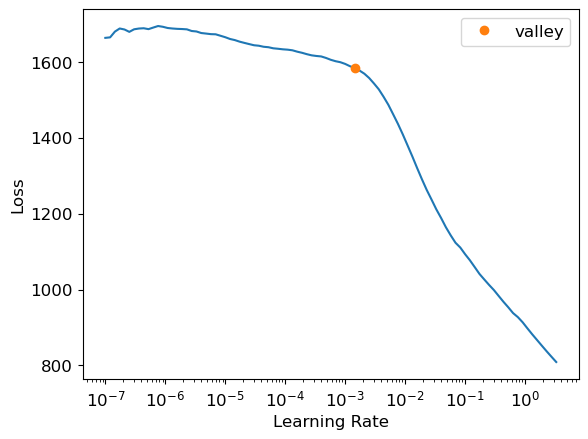

In [126]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,29.651646,129.511414,01:10
1,26.284279,126.484634,01:10
2,22.842846,105.787109,01:09


In [119]:
# learn.fit_one_cycle(10, 1e-4,wd=0.1, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,time
0,20.536901,101.327255,01:20
1,22.916550,121.310318,01:22


No improvement since epoch 0: early stopping


In [131]:
preds,targs = learn.get_preds()
r_mse(preds, targs)

9.382001

In [132]:
rf_preds = m_rf.predict(valid_xs)

ens_preds = (to_np(preds.squeeze())+rf_preds)/2

In [133]:
r_mse(ens_preds, valid_y)

6.100121